In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shutil

In [2]:
img_height = 432
img_width = 288
train_Mel_spec_directory = './data_eval/img_data/dustan/mel_spectrogram/allclass/'
train_MFCC_directory = './data_eval/img_data/dustan/MFCC_5_class/'


In [3]:
def dummy(data,numarr):
    new_data =[]
    for i in data:
        lab_data = []
        for j in range(0,numarr):
            lab_data.append(0)
        #lab_data =[0,0]
        lab_data[i] = 1
        new_data.append(lab_data)
    return new_data

In [4]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight 

In [5]:

def createdict(num):
    lab_data = []
    for i in range(0,num):
        lab_data.append(i)
    dic = dict.fromkeys(lab_data, 0)
    return dic

In [6]:
def createWeight(class_count,num_classes):
    class_weights = createdict(num_classes)
    for i in range(num_classes):
        class_weights[i]=create_weight(np.sum(class_count),num_classes,class_count[i])
    return class_weights

In [7]:
def preprocess(data_dir,numclass):
    data_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, labels='inferred', label_mode='int', image_size=(432, 288), seed=321,
    validation_split=None, subset=None)
    class_names = data_ds.class_names
    
    feature=[]
    label=[]
    for images, labels in data_ds.unbatch().take(-1):
        feature.append(images.numpy())
        label.append(labels.numpy())
        
    feature = np.array(feature)
    label = np.array(label)      
    
    
    class_count=[]
    for i in range(0,numclass):
        class_count.append(np.count_nonzero(label == i))
    class_count = np.array(class_count)
    label = dummy(label,numclass)
    class_weights = createWeight(class_count,numclass)
   
    
    label = np.array(label)
    return feature,label,class_weights,class_names
    

In [8]:
mel_feature,mel_label,class_weights,class_names = preprocess(train_Mel_spec_directory,5)

Found 180 files belonging to 5 classes.


In [9]:
mfcc_feature,mfcc_label,class_weights,class_names = preprocess(train_MFCC_directory,5)

Found 180 files belonging to 5 classes.


In [10]:
class_names

['burping', 'discomfort', 'hungry', 'poop', 'tired']

In [11]:
def categories2binary(categories):
    binarydata = []
    for item in categories:
        binarydata.append(item[0])
    binarydata=np.array(binarydata)
    return(binarydata)

In [12]:
def binary2categories(binary):
    new_data = []
    for i in binary:
        lab_data = []
        for j in range(0,2):
            lab_data.append(0)
        if(i>=0.5):
            lab_data[1]=1;
        elif(i<0.5):
            lab_data[0]=1;
        new_data.append(lab_data)
    new_data = np.array(new_data)
    return(new_data)

In [13]:
mfcc_base_model = tf.keras.applications.ResNet50(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
mfcc_base_model.trainable = False

# Create new model on top

mfcc_inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x_mfcc = mfcc_inputs

x_mfcc = mfcc_base_model(x_mfcc, training=False)

# x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x_mfcc = tf.keras.layers.MaxPooling2D((2,2))(x_mfcc)
x_mfcc = tf.keras.layers.Flatten()(x_mfcc)


x_mfcc = tf.keras.layers.Dense(64, activation='relu')(x_mfcc)


In [14]:
mel_base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
mel_base_model.trainable = False

# Create new model on top

mel_inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x_mel = mel_inputs

x_mel = mel_base_model(x_mel, training=False)

# x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)          
x_mel = tf.keras.layers.MaxPooling2D((2,2))(x_mel)
x_mel = tf.keras.layers.Flatten()(x_mel)


x_mel = tf.keras.layers.Dense(64, activation='relu')(x_mel)


In [15]:
combined = tf.keras.layers.Concatenate(axis=1)([x_mel, x_mfcc])
combined = tf.keras.layers.Dropout(0.15)(combined)
output = tf.keras.layers.Dense(5, activation="softmax")(combined)
mix_model =tf.keras.Model(inputs=[mel_inputs, mfcc_inputs] , outputs=output)
mix_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 432, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 432, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50v2 (Functional)        (None, 14, 9, 2048)  23564800    ['input_4[0][0]']                
                                                                                              

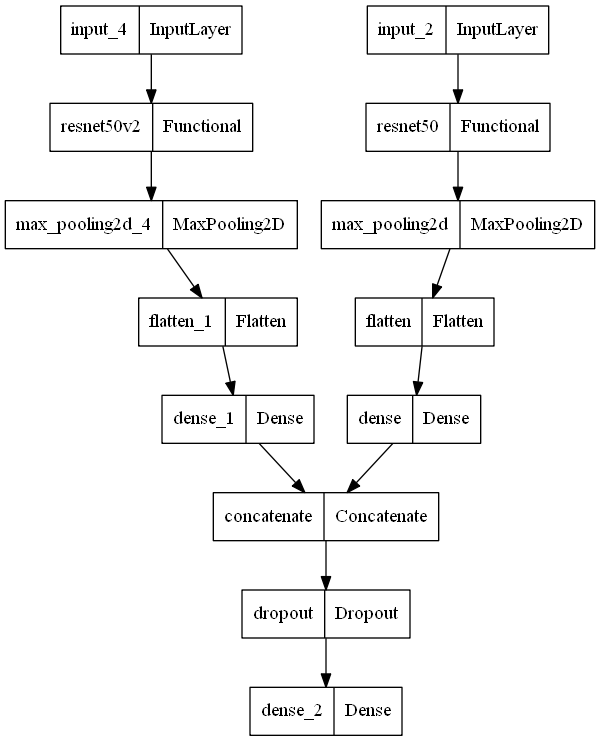

In [16]:
tf.keras.utils.plot_model(mix_model)

Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 69s 13s/step - loss: 694.5627 - accuracy: 0.2292 - val_loss: 1225.8431 - val_accuracy: 0.1111
Epoch 2/100
5/5 [==============================] - 51s 11s/step - loss: 451.1129 - accuracy: 0.3056 - val_loss: 185.9409 - val_accuracy: 0.3611
Epoch 3/100
5/5 [==============================] - 48s 10s/step - loss: 51.4259 - accuracy: 0.5278 - val_loss: 10.4508 - val_accuracy: 0.3611
Epoch 4/100
5/5 [==============================] - 49s 10s/step - loss: 6.4154 - accuracy: 0.5486 - val_loss: 3.5849 - val_accuracy: 0.5000
Epoch 5/100
5/5 [==============================] - 51s 11s/step - loss: 2.4157 - accuracy: 0.6319 - val_loss: 3.1907 - val_accuracy: 0.4444
Epoch 6/100
5/5 [==============================] - 51s 10s/step - loss: 2.3043 - accuracy: 0.6042 - val_loss: 2.4730 - val_accuracy: 0.4722
Epoch 7/100
5/5 [==============================] - 51s 10s/step - loss: 1.3575 - accuracy: 0.6875 - val_loss: 1.1709 - val_accuracy: 0.5000
Epoch 8/100
5/5 [====

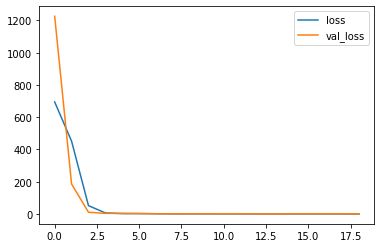

In [17]:

loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
mix_model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = mix_model.fit([mel_feature,mfcc_feature], mel_label, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()



Epoch 1/100


c:\Users\acer\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 95s 17s/step - loss: 0.2372 - accuracy: 0.9167 - val_loss: 1.1433 - val_accuracy: 0.6944
Epoch 2/100
5/5 [==============================] - 87s 17s/step - loss: 0.2725 - accuracy: 0.9028 - val_loss: 1.2096 - val_accuracy: 0.6944
Epoch 3/100
5/5 [==============================] - 89s 18s/step - loss: 0.1768 - accuracy: 0.9167 - val_loss: 1.2477 - val_accuracy: 0.7222
Epoch 4/100
5/5 [==============================] - 116s 24s/step - loss: 0.1386 - accuracy: 0.9583 - val_loss: 1.1877 - val_accuracy: 0.6944
Epoch 5/100
5/5 [==============================] - 114s 23s/step - loss: 0.1646 - accuracy: 0.9167 - val_loss: 1.2317 - val_accuracy: 0.7222
Epoch 6/100
5/5 [==============================] - 114s 23s/step - loss: 0.1505 - accuracy: 0.9514 - val_loss: 1.2688 - val_accuracy: 0.7222


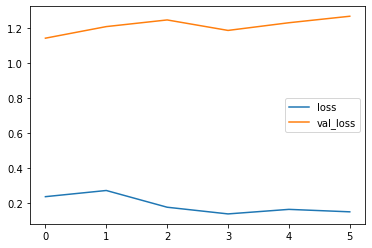

In [18]:

mel_base_model.trainable = True
loss_fn = tf.keras.losses.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(1e-4)# modify weight in Adam
metrics = ['accuracy']
mix_model.compile(optimizer = optimizer,loss =  loss_fn,metrics = metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
epochs = 100
history = mix_model.fit([mel_feature,mfcc_feature], mel_label, epochs=epochs,validation_split=0.2,callbacks=callback,class_weight = class_weights)

plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [19]:
import shutil
from pydub import AudioSegment
import time

c:\Users\acer\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [20]:
def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        # Load audio
        waveform, sample_rate = load_audio(file_path)
        audio_segment = AudioSegment.from_file(file_path)
        dataset.append([waveform, sample_rate,audio_segment])

    return dataset


In [21]:
def mel_spectrogram(waveform,sample,n_fft=2560,hop_length=32):
    #fast_fourier_transf = np.fft.fft(waveform)
   
    audio_stft = librosa.feature.melspectrogram(y=waveform,n_fft=n_fft,hop_length=hop_length,fmin = 20,fmax = sample//2)
    log_spectro = librosa.power_to_db(audio_stft)
    librosa.display.specshow(log_spectro, sr=sample, x_axis='time', y_axis='mel',cmap = 'magma')
    
    
    return log_spectro

In [22]:
def mel_freq(waveform,sample):
    mfccs = librosa.feature.mfcc(waveform, sr=sample,dct_type = 2,n_mfcc=100)
    # data = librosa.power_to_db(mfccs)
    # Displaying  the MFCCs:
    librosa.display.specshow(mfccs, sr=sample, x_axis='mel',cmap = 'magma')
    return mfccs

In [23]:
def create_images(data,typeimg):
    # make directory

    test_directory = f'./testImgArea/y_label/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    sample_rate = data[1]
    waveform = data[0]
    if typeimg == 'mel_spectrogram':
        spectrogram = mel_spectrogram(waveform,sample_rate)
    elif typeimg == 'mel_freq':
        spectrogram = mel_freq(waveform,sample_rate)
    librosa.display.specshow(spectrogram,sr=sample_rate, x_axis='time')
    plt.axis('off')
    plt.savefig(f'./testImgArea/y_label/test_{typeimg}.jpg', bbox_inches="tight", pad_inches = 0)
    plt.clf()

In [24]:
def getTestData():
    
    data_ds = tf.keras.preprocessing.image_dataset_from_directory('./testImgArea/', labels='inferred', label_mode='int', image_size=(432, 288), seed=321,validation_split=None, subset=None)
    fe=[]
    lab=[]
    for images, labels in data_ds.unbatch().take(-1):
        fe.append(images.numpy())
        lab.append(labels.numpy())

    return np.array(fe),np.array(lab)

In [25]:
predictset= []
labelset = []

In [26]:
def predict_infant(class_test_data,y_label):
    for testobj in class_test_data:
        create_images(testobj,typeimg ='mel_spectrogram')
        
        x_mel,y = getTestData()
        os.remove('./testImgArea/y_label/test_mel_spectrogram.jpg')
        create_images(testobj,typeimg ='mel_freq')
        x_mfcc,y = getTestData()
        os.remove('./testImgArea/y_label/test_mel_freq.jpg')
        pred = mix_model.predict(x=[x_mel,x_mfcc])
        y_pred_class = np.argmax(pred, axis=1)
        predictset.append(y_pred_class)
        labelset.append(y_label)
        plt.clf()
    

In [27]:
burping_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/burpme/', 'burpme')
tired_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/tired_owh/', 'tired')
hungry_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/hungry_Nah/', 'hungry')
poop_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/poop_eairh/', 'poop')
discomfort_test_data = load_audio_files('./data_eval/sound_data/dustan_baby/test/uncomfortable_heh/', 'discomfort')

In [28]:
class_names

['burping', 'discomfort', 'hungry', 'poop', 'tired']

In [29]:
predict_infant(discomfort_test_data,1)
predict_infant(hungry_test_data,2)
predict_infant(tired_test_data,4)
predict_infant(burping_test_data,0)
predict_infant(poop_test_data,3)

Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.01826506  0.02153401  0.01889604 ... -0.01740496 -0.01061663
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00342632  0.00536773 -0.00193395 ... -0.00189459 -0.00193687
 -0.00111701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-2.22406862e-03 -2.80658191e-04 -1.24698445e-05 ... -6.10173738e-04
 -1.26449310e-03 -8.37345957e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00158096 -0.00058495  0.00041521 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-7.2082999e-04  1.0061060e-04  6.0616271e-04 ...  2.2113488e-06
 -3.5017154e-06  2.3880630e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-6.6591293e-04 -6.2257306e-05  1.9816967e-04 ...  3.0344967e-03
  1.3053697e-03  5.6547532e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00119781 -0.00131018 -0.00325518 ...  0.01092438  0.01495741
  0.01029418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00752398 -0.00712848 -0.00551579 ...  0.00132812 -0.0019003
 -0.00157612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 2.0982519e-05 -1.2052179e-04 -3.9785878e-05 ... -7.8898756e-04
 -1.5072785e-03 -1.3643949e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 2.9545579e-05 -4.9479731e-04 -9.9617813e-04 ...  1.4621929e-04
 -5.8426510e-04 -6.2609575e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.000000e+00  0.000000e+00  0.000000e+00 ...  8.304395e-06 -8.036209e-06
  2.385550e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.6487282e-05 5.7365134e-05
 4.5457244e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 2.1817222e-04  6.6967349e-04  1.2087843e-03 ... -4.8739534e-05
 -4.8853373e-05 -4.4802127e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 8.4612910e-03  1.2294165e-02  1.2405651e-02 ... -1.5273430e-04
  1.0270798e-05 -1.2608814e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.0013659  -0.00148018 -0.00362076 ...  0.00021674 -0.00020186
 -0.00037947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00535197  0.00262586 -0.01136751 ...  0.00023181  0.000245
 -0.00087051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[2.43558825e-04 3.24570428e-04 2.93259400e-05 ... 1.05076724e-04
 1.37050811e-04 4.26761835e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-5.5798853e-05 -4.8092857e-05 -1.9396152e-04 ... -2.1212539e-04
 -3.3878576e-04 -1.5401404e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00038535 -0.00037327  0.0001367  ...  0.00801643  0.01602553
  0.0125422 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.00630017 0.00433352 0.00057668 ... 0.07097128 0.07848126 0.05098138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.         0.         0.         ... 0.00052199 0.0006206  0.0003703 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00945313  0.00768792  0.00011147 ... -0.00066999 -0.00058385
 -0.00035691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.00604864 0.0039892  0.00109056 ... 0.00040361 0.00037618 0.00027061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00052588 -0.00023468 -0.00014387 ... -0.00460483 -0.01389482
 -0.01396289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.01109072  0.0026508   0.01566025 ...  0.00808063 -0.00842551
 -0.00988047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.0219384  -0.03610521 -0.04121292 ...  0.00415176 -0.00049871
 -0.00027296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.00167727 0.00196662 0.00219803 ... 0.00245697 0.00165155 0.00018538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-3.19347018e-03  1.44778905e-05  5.84236870e-04 ...  7.24603375e-03
  4.74215485e-03  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.07763471 0.08898661 0.05047784 ... 0.00486038 0.00106889 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.00167722 -0.00403281 -0.01083838 ...  0.00197309  0.00179204
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00957653 -0.00087309  0.00341467 ...  0.00233265  0.00084321
  0.00015825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.01131302  0.00100288  0.00415186 ...  0.00156032 -0.00115382
 -0.00261397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.10774724  0.06230866 -0.01584756 ... -0.00020849  0.00226478
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.02615045  0.03966736  0.0441599  ... -0.00211605 -0.00079206
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.01936157  0.01840827  0.00508931 ... -0.00188933 -0.00301706
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[0.03334832 0.03737337 0.05838627 ... 0.00760775 0.00983772 0.00656914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00129016  0.00077069 -0.00281001 ... -0.00270263 -0.00225433
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00399717  0.00125982  0.00081104 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.0979365  -0.11278865 -0.084534   ... -0.00063468 -0.00058066
 -0.00023474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.02463757 -0.02782968 -0.02153574 ... -0.01081211 -0.00922692
 -0.00578547] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.02669469 -0.01052689 -0.001286   ...  0.03470214  0.01041044
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 3.9800727e-03 -3.6827911e-05 -1.6235712e-03 ... -4.3132924e-03
 -5.4474017e-03 -3.4463792e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.

c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-0.00607234  0.01062527  0.00734523 ... -0.01155577 -0.01760191
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  



Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[ 0.02317526  0.00584447 -0.02619953 ...  0.00846163  0.00892048
  0.00517641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.
Found 1 files belonging to 1 classes.


c:\Users\acer\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Pass y=[-1.4225706e-03  2.7529712e-04  8.6953578e-04 ... -1.2320284e-05
 -5.5264823e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  


Found 1 files belonging to 1 classes.


<Figure size 432x288 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       1.00      0.86      0.92         7
           2       0.70      0.88      0.78         8
           3       0.83      1.00      0.91        10
           4       1.00      0.82      0.90        11

    accuracy                           0.90        48
   macro avg       0.91      0.89      0.89        48
weighted avg       0.92      0.90      0.90        48



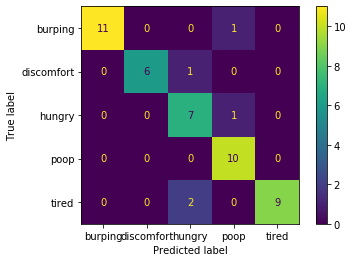

In [30]:

cm = confusion_matrix(labelset, predictset)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = class_names)
disp.plot()
plt.show

from sklearn.metrics import classification_report
print(classification_report(labelset, predictset))

In [32]:
mix_model.save('./h5_model/mix_model.h5')